In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import preprocessing
import visualization
import librosa
from copy import deepcopy as dc

# Visualizing the signal

I plot the signal with different colors correspond to different waveforms

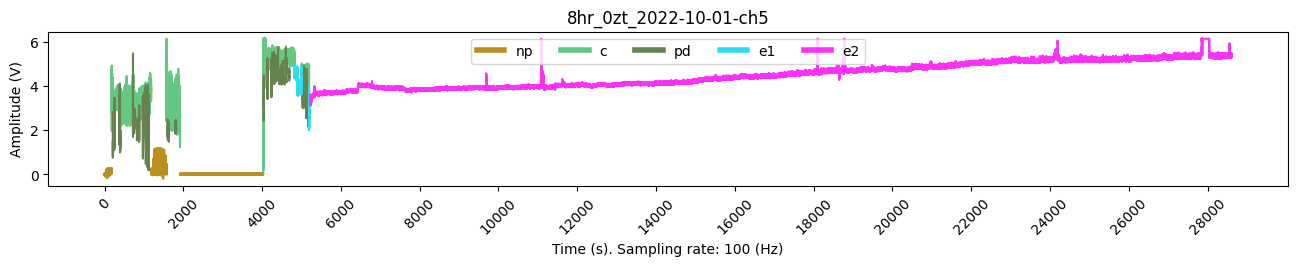

In [252]:
filename = ['8hr_0zt_2022-10-01-ch5']
analysis_filename = ['0zt_22-10-01-ch5_.ANA']
extension = ['.A01','.A02','.A03','.A04','.A05','.A06','.A07','.A08']
os.chdir('C:\\Users\\My PC\\Desktop\\Data from Daniel\\0zt')
data = {}
data[filename[0]] = [preprocessing.read_wave(filename[0],extension),preprocessing.read_analysis(analysis_filename[0])]
data[filename[0]] = preprocessing.outlier_filtering(data[filename[0]][0],data[filename[0]][1])

wave_array = data[filename[0]][0]
ana = data[filename[0]][1]

visualization.visualize_wave(wave_array,ana)
plt.title(f'{filename[0]}')
plt.show()

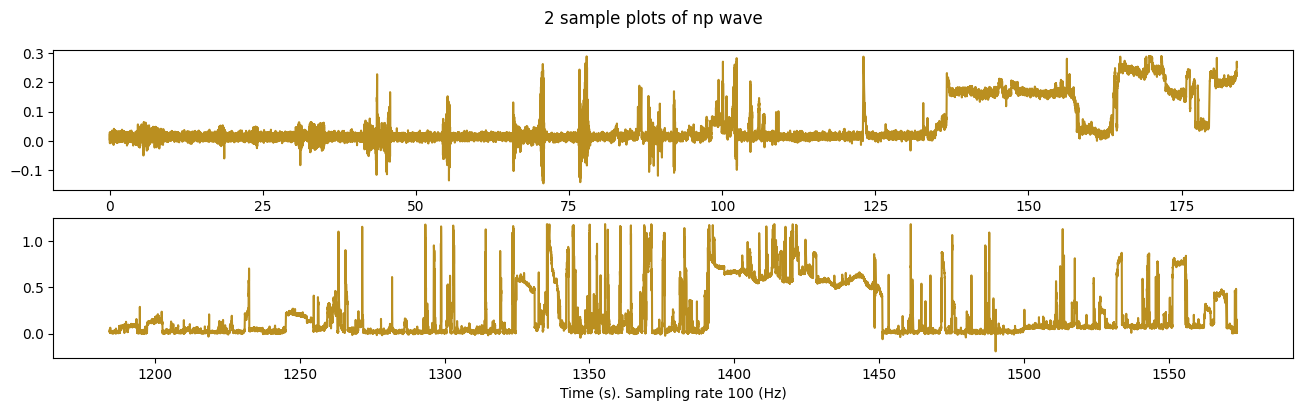

In [8]:
visualization.visualize_wave(wave_array,ana,'np',n_plots = 2)

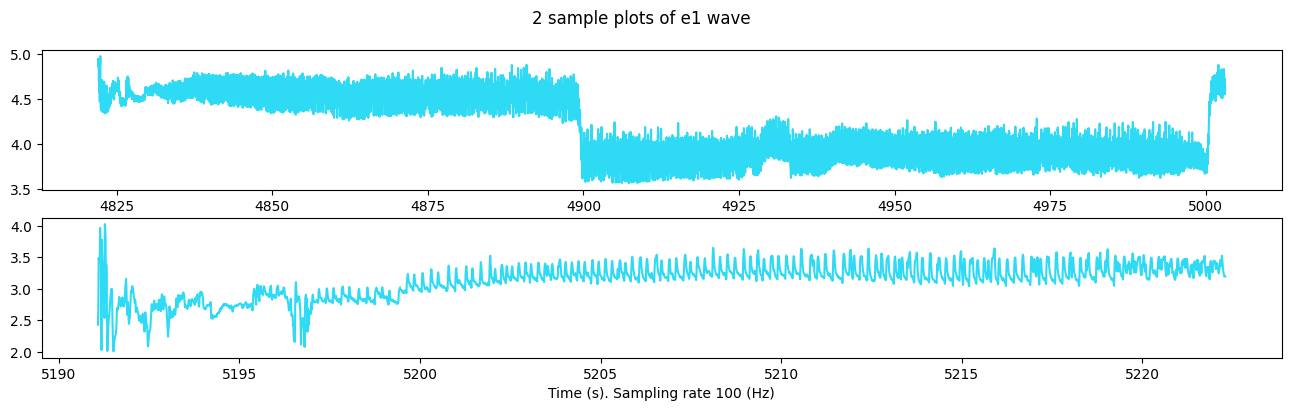

In [253]:
visualization.visualize_wave(wave_array,ana,'e1',n_plots = 2)

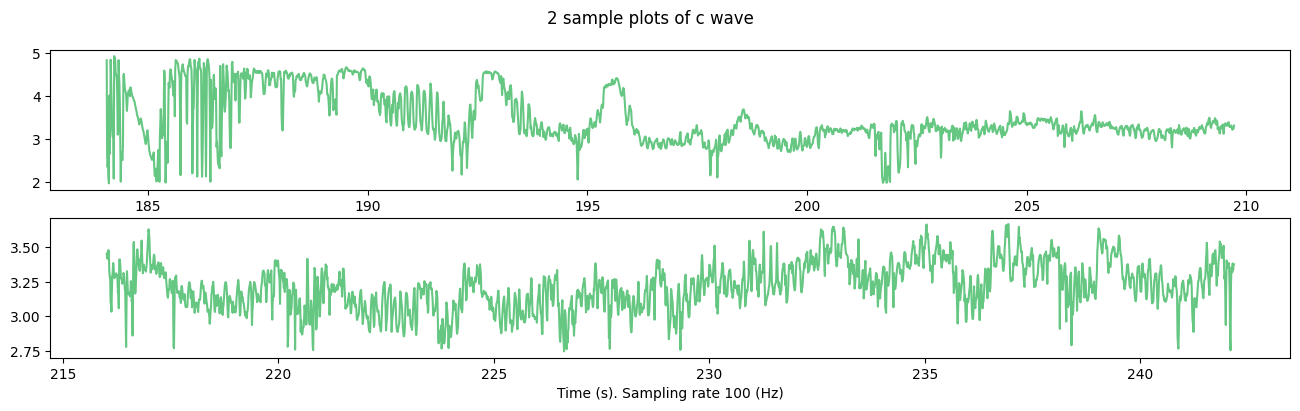

In [255]:
visualization.visualize_wave(wave_array,ana,'c',n_plots = 2)

# Wavelet transform

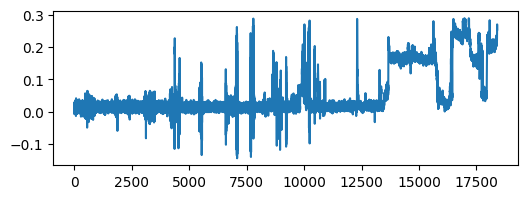

In [256]:
sample = preprocessing.extract_sample(wave_array,ana,'np',0)
plt.figure(figsize=(6,2))
plt.plot(sample)

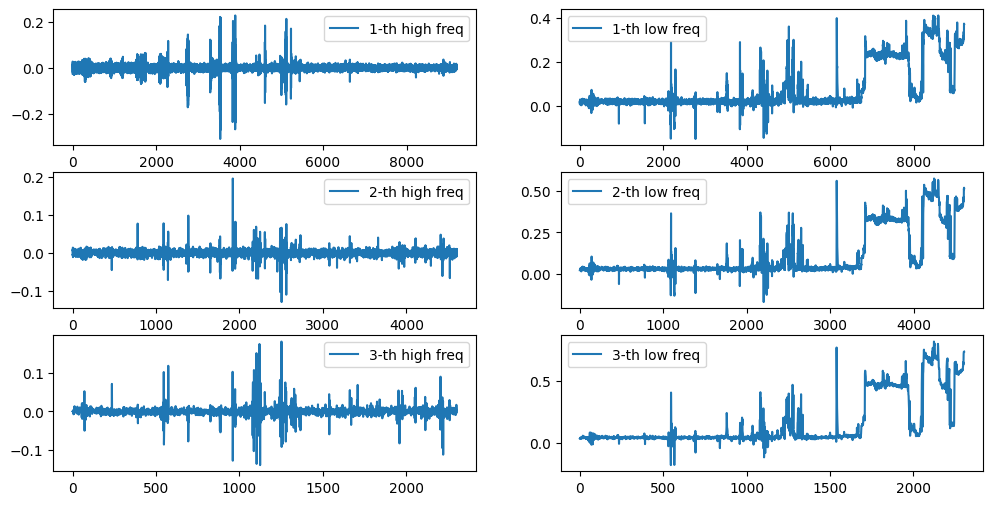

In [257]:
low_freq,high_freq = preprocessing.get_wavelet_coefficients(sample,'sym4',n_level=3)
visualization.visualize_wavelet_coefficients(low_freq,high_freq)

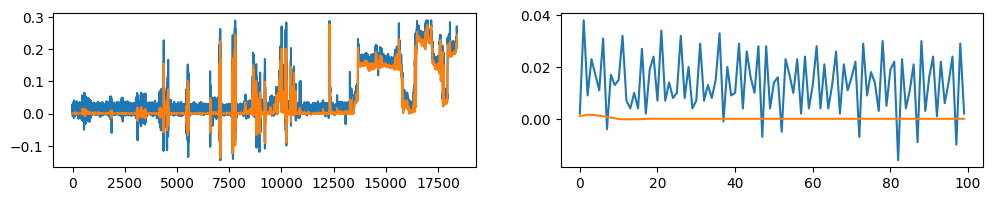

In [258]:
_,(ax1,ax2) = plt.subplots(1,2,figsize = (12,2))
denoised_sample = preprocessing.wavelet_denoising(sample,'sym4',3)
ax1.plot(sample)
ax1.plot(denoised_sample)
ax2.plot(sample[200:300])
ax2.plot(denoised_sample[200:300])

**Comment** We need to be careful with denoising using wavelet transform because it might deletes some useful periodic behavior in the waves, as in the above figure

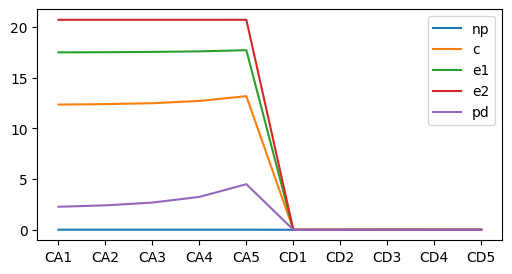

In [259]:
wave_array = data[filename[0]][0]
ana = data[filename[0]][1]

npw = preprocessing.extract_sample(wave_array,ana,'np',0)
c = preprocessing.extract_sample(wave_array,ana,'c',0)
e1 = preprocessing.extract_sample(wave_array,ana,'e1',0)
e2 = preprocessing.extract_sample(wave_array,ana,'e2',0)
pd = preprocessing.extract_sample(wave_array,ana,'pd',0)

samples = [npw,c,e1,e2,pd]
name = ['np','c','e1','e2','pd']

plt.figure(figsize = (6,3))
for i in range(5):
    low_freq,high_freq = preprocessing.get_wavelet_coefficients(samples[i],'sym4',5)
    ae_low, ae_high = preprocessing.average_energy(low_freq,high_freq)
    plt.plot(ae_low+ae_high,label = name[i])

plt.xticks(ticks = np.arange(0,2*len(ae_low)),labels = [f'CA{k+1}' for k in range(5)] + [f'CD{k+1}' for k in range(5)])
plt.legend()
plt.show()

This is a plot of the average of the square of the low and high frequencies wavelet coefficients. \
We can see that the waves differs mostly in the approximation coefficients (low freq) rather than the detail (high freq)

Next we try to generate an array of signal segments of length 1024 and label them according to the corresponding waveforms label.

In [23]:
d,lab = preprocessing.generate_model_data(data)
enc = preprocessing.numeric_encoder()
lab = enc.fit_transform(lab)
print(np.unique(lab,return_counts = True))
print(enc.labels_dict)

Included files: ['8hr_0zt_2022-10-01-ch5']
Model data shape: (11340, 1024),label shape: (11340,)
(array([0, 1, 2, 3, 5]), array([1037,  744,   76, 9133,  350], dtype=int64))
{'np': 0, 'c': 1, 'e1': 2, 'e2': 3, 'f': 4, 'pd': 5, 'g': 6}


We calculate the information relateed to each segment

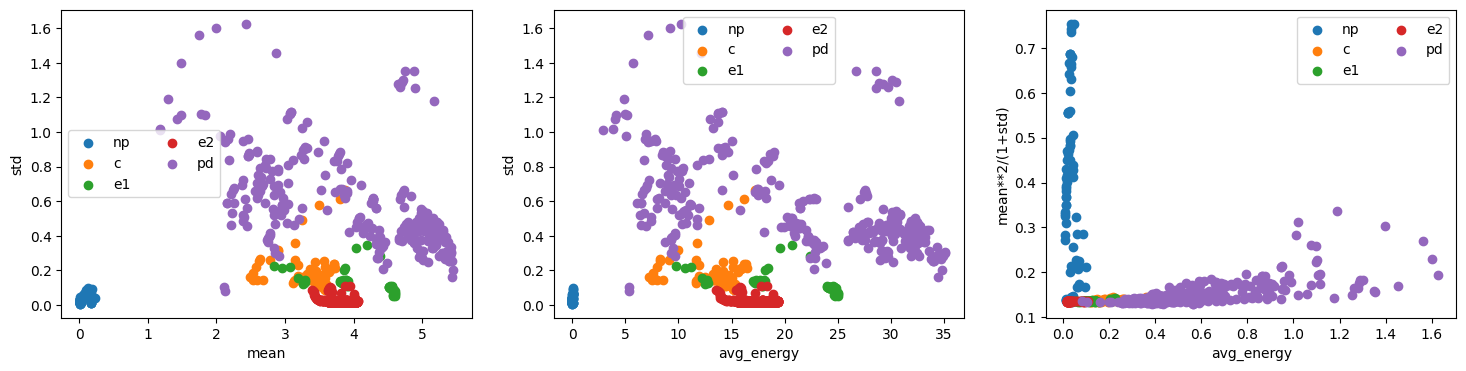

In [260]:
from EntropyHub import SpecEn
#The informations contains [mean,std,average_energy_of_the_3_resolution,spectral_entropy]
info_np = []
info_c = []
info_e1 = []
info_e2 = []
info_f = []
info_pd = []
info = [info_np,info_c,info_e1,info_e2,info_f,info_pd]
for i in range(len(d)):
    low_freq,high_freq = preprocessing.get_wavelet_coefficients(d[i,:],'sym4',5)
    low_freq,_ = preprocessing.average_energy(low_freq,high_freq)
    info[lab[i]].append([np.mean(d[i,:]),np.std(d[i,:]),low_freq[4],SpecEn(d[i,:])[0]])

plt.figure(figsize = (18,4))
plt.subplot(1,3,1)
n = 75
plt.scatter(np.array(info[0])[:n,0],np.array(info[0])[:n,1],label = 'np')
plt.scatter(np.array(info[1])[:n,0],np.array(info[1])[:n,1],label = 'c')
plt.scatter(np.array(info[2])[:n,0],np.array(info[2])[:n,1],label = 'e1')
plt.scatter(np.array(info[3])[:1000,0],np.array(info[3])[:1000,1],label = 'e2')
# plt.scatter(np.array(info[4])[:n,0],np.array(info[4])[:n,1],label = 'f')
plt.scatter(np.array(info[5])[:500,0],np.array(info[5])[:500,1],label = 'pd')
plt.legend(ncol = 2)
plt.xlabel('mean')
plt.ylabel('std')

plt.subplot(1,3,2)
n = 75
plt.scatter(np.array(info[0])[:n,2],np.array(info[0])[:n,1],label = 'np')
plt.scatter(np.array(info[1])[:n,2],np.array(info[1])[:n,1],label = 'c')
plt.scatter(np.array(info[2])[:n,2],np.array(info[2])[:n,1],label = 'e1')
plt.scatter(np.array(info[3])[:1000,2],np.array(info[3])[:1000,1],label = 'e2')
# plt.scatter(np.array(info[4])[:n,2],np.array(info[4])[:n,1],label = 'f')
plt.scatter(np.array(info[5])[:500,2],np.array(info[5])[:500,1],label = 'pd')
plt.legend(ncol = 2)
plt.xlabel('avg_energy')
plt.ylabel('std')

plt.subplot(1,3,3)
n = 75
plt.scatter(np.array(info[0])[:n,1],np.array(info[0])[:n,3],label = 'np')
plt.scatter(np.array(info[1])[:n,1],np.array(info[1])[:n,3],label = 'c')
plt.scatter(np.array(info[2])[:n,1],np.array(info[2])[:n,3],label = 'e1')
plt.scatter(np.array(info[3])[:n,1],np.array(info[3])[:n,3],label = 'e2')
# plt.scatter(np.array(info[4])[:n,1],np.array(info[4])[:n,3],label = 'f')
plt.scatter(np.array(info[5])[:500,1],np.array(info[5])[:500,3],label = 'pd')
plt.legend(ncol = 2)
plt.xlabel('avg_energy')
plt.ylabel('mean**2/(1+std)')
plt.show()

# Filter the Outlier

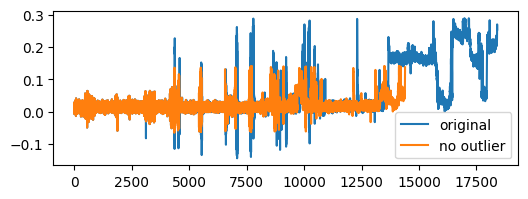

In [267]:
#This demonstrate the outlier filtering process
plt.figure(figsize = (6,2))
outlier_filtered_sample = preprocessing.outlier_filtering(wave_array = sample,option = 'indiv')
outlier_filtered_denoised_sample = preprocessing.wavelet_denoising(outlier_filtered_sample,'sym4',3)
plt.plot(sample,label = 'original')
plt.plot(outlier_filtered_sample,label = 'no outlier')

plt.legend()


# Fast Fourier transform

n_coefs: 513,n_windows: 68
n_coefs: 513,n_windows: 7
Shorter than window_size
n_coefs: 513,n_windows: 5
n_coefs: 513,n_windows: 67


c:\Users\My PC\Desktop\Data from Daniel\visualization.py:96: RuntimeWarning: divide by zero encountered in log
  wave_sample_stft = np.log(wave_sample_stft)


n_coefs: 513,n_windows: 9133


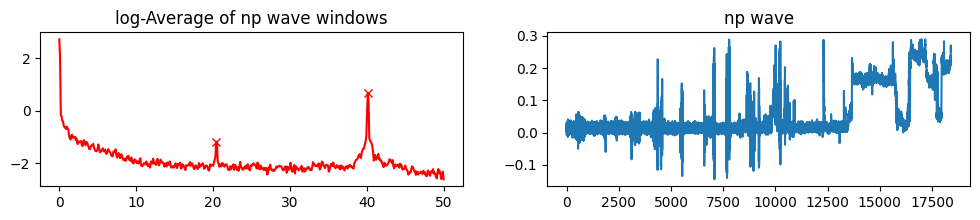

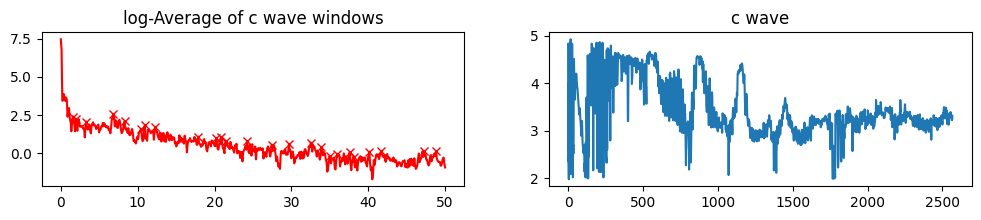

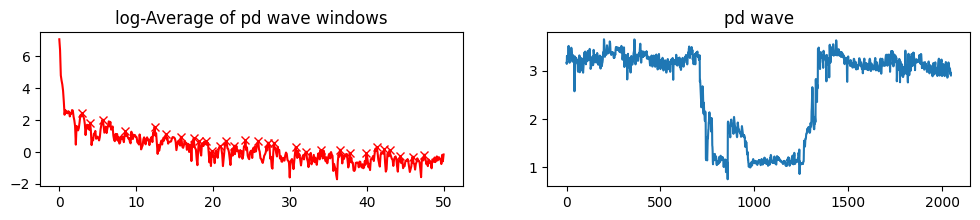

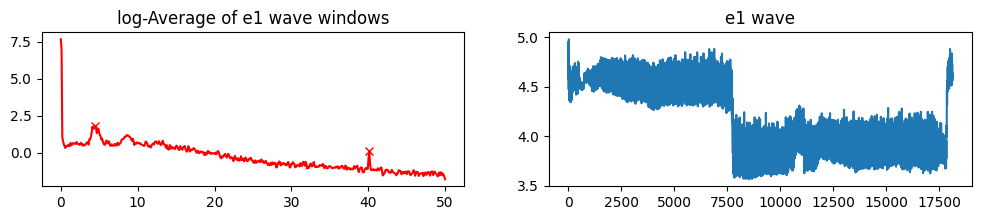

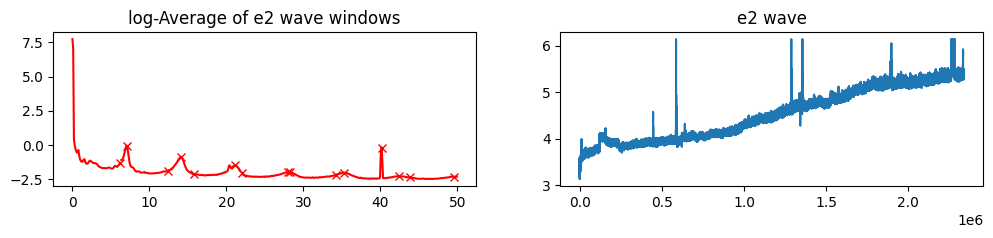

In [268]:
visualization.visualize_fft_coefficients(wave_array,ana,'np',0,True)
visualization.visualize_fft_coefficients(wave_array,ana,'c',0,True)
visualization.visualize_fft_coefficients(wave_array,ana,'pd',0,True)
visualization.visualize_fft_coefficients(wave_array,ana,'e1',0,True)
visualization.visualize_fft_coefficients(wave_array,ana,'e2',0,True)

n_coefs: 513,n_windows: 9133


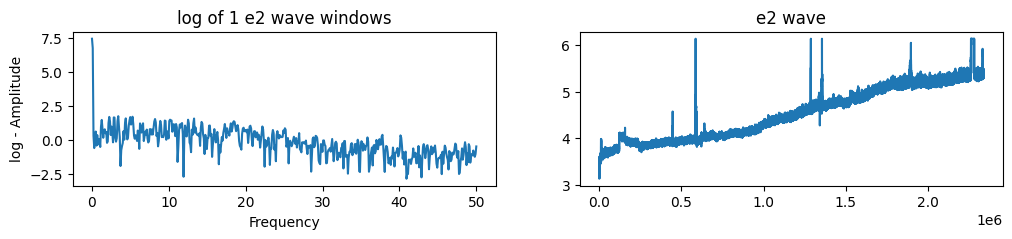

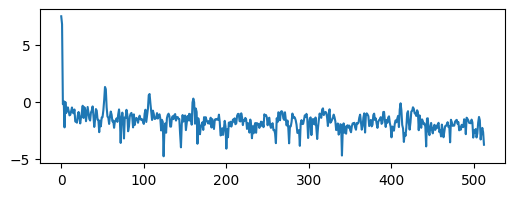

In [322]:
visualization.visualize_fft_coefficients(wave_array,ana,'e2',0,False,n_wind = 1)
i = 30
e2 = extract_sample(wave_array,ana,'e2',0)[1024*i:1024*(i+1)]
plt.figure(figsize = (6,2))
plt.plot(np.log(np.abs(librosa.stft(e2,n_fft=1024,center = False))))

In [ ]:
# import numpy as np
# class real_time_peak_detection():
#     def __init__(self, array, lag, threshold, influence):
#         self.y = list(array)
#         self.length = len(self.y)
#         self.lag = lag
#         self.threshold = threshold
#         self.influence = influence
#         self.signals = [0] * len(self.y)
#         self.filteredY = np.array(self.y).tolist()
#         self.avgFilter = [0] * len(self.y)
#         self.stdFilter = [0] * len(self.y)
#         self.avgFilter[self.lag - 1] = np.mean(self.y[0:self.lag]).tolist()
#         self.stdFilter[self.lag - 1] = np.std(self.y[0:self.lag]).tolist()

#     def thresholding_algo(self, new_value):
#         self.y.append(new_value)
#         i = len(self.y) - 1
#         self.length = len(self.y)
#         if i < self.lag:
#             return 0
#         elif i == self.lag:
#             self.signals = [0] * len(self.y)
#             self.filteredY = np.array(self.y).tolist()
#             self.avgFilter = [0] * len(self.y)
#             self.stdFilter = [0] * len(self.y)
#             self.avgFilter[self.lag] = np.mean(self.y[0:self.lag]).tolist()
#             self.stdFilter[self.lag] = np.std(self.y[0:self.lag]).tolist()
#             return 0

#         self.signals += [0]
#         self.filteredY += [0]
#         self.avgFilter += [0]
#         self.stdFilter += [0]

#         if abs(self.y[i] - self.avgFilter[i - 1]) > (self.threshold * self.stdFilter[i - 1]):

#             if self.y[i] > self.avgFilter[i - 1]:
#                 self.signals[i] = 1
#             else:
#                 self.signals[i] = -1

#             self.filteredY[i] = self.influence * self.y[i] + \
#                 (1 - self.influence) * self.filteredY[i - 1]
#             self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
#             self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])
#         else:
#             self.signals[i] = 0
#             self.filteredY[i] = self.y[i]
#             self.avgFilter[i] = np.mean(self.filteredY[(i - self.lag):i])
#             self.stdFilter[i] = np.std(self.filteredY[(i - self.lag):i])

#         return self.signals[i]

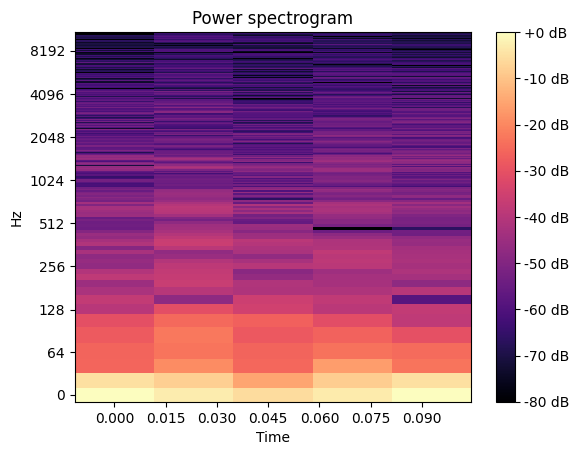

In [205]:
import matplotlib.pyplot as plt
# sample = extract_sample(wave_array,ana,'pd',0)[4096:6120]

coef = np.abs(librosa.stft(wave_array[start:end],n_fft=1024,center = False))
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(coef,
                                                       ref=np.max),
                               y_axis='log', x_axis='time', ax=ax)
ax.set_title('Power spectrogram')
fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [100]:
# from scipy.signal import find_peaks
# plt.figure(figsize = (6,3))
# peaks = {c:coef[c] for c in peaks_idx}
# greatest_peaks_idx = sorted(peaks,key=peaks.get,reverse=True)[:5]
# peaks_features = coef[greatest_peaks_idx]
# peaks_features = peaks_features/np.linalg.norm(peaks_features,2)
# sample = extract_sample(wave_array,ana,'c',7)
# coef = np.log(np.abs(librosa.stft(sample,n_fft = 1024,center = False)))
# coef = np.sum(coef,axis = 1)/coef.shape[1] #average
# peaks_idx = find_peaks(coef,prominence = 0.7)[0]
# plt.plot(peaks_idx, coef[peaks_idx ], "xr"); plt.plot(coef); plt.legend(['distance'])

In [101]:
# from peakdetect import peakdetect
# sample = extract_sample(wave_array,ana,'c',7)
# coef = np.log(np.abs(librosa.stft(sample,n_fft = 1024,center = False)))
# coef = np.sum(coef,axis = 1)/coef.shape[1] #average
# # coef = np.log(np.sum(stft_coef,axis=0))/stft_coef.shape[0]

# peaks = peakdetect(coef, lookahead=15) 
# # Lookahead is the distance to look ahead from a peak to determine if it is the actual peak. 
# # Change lookahead as necessary 
# higherPeaks = np.array(peaks[0])
# lowerPeaks = np.array(peaks[1])
# plt.plot(coef)
# plt.plot(higherPeaks[:,0], higherPeaks[:,1], 'ro')
# plt.plot(lowerPeaks[:,0], lowerPeaks[:,1], 'ko')

In [118]:
wave_idx = preprocessing.get_index(ana)

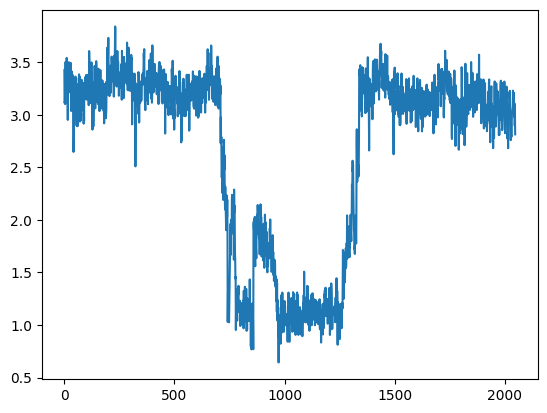

In [250]:
start,end = wave_idx['pd'][0]
start,end = (start+end)//2 - 1024, (start+end)//2 + 1024
plt.plot(wave_array[start:end]+np.random.normal(0,0.1,2048))

In [172]:
def upsample(wave_array):
    up = np.zeros(len(wave_array)*2)
    for i in range(len(wave_array)):
        up[2*i] = wave_array[i]
    for i in range(len(wave_array)-1):
        up[2*i+1] = (up[2*i]+ up[2*i+2])/2
    return up

In [218]:
sample = preprocessing.extract_sample(wave_array,ana,'np',0)

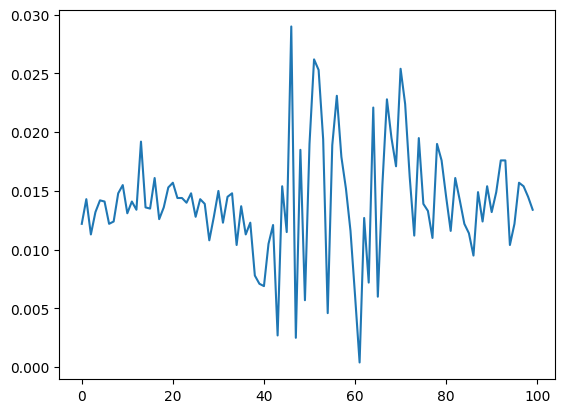

In [219]:
plt.plot(preprocessing.downsampling(sample)[0:100])

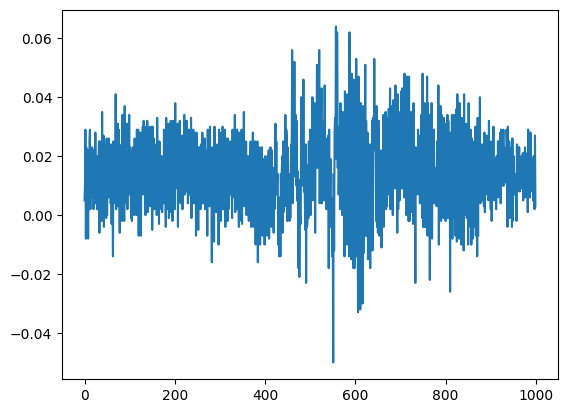

In [222]:
plt.plot(sample[0:1000])